In [3268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from shapely.ops import split,nearest_points
from shapely.geometry import LineString,Polygon,Point, MultiPolygon
import networkx as nx
from shapely.affinity import translate
from newton_multidimention import Optimize_Drone_Position_Euclidean_cap_1

## Creating delivary locations

In [3269]:
def create_delivary(x,y,n):
    x_range = [x[0], y[0]]
    y_range = [x[1], y[1]]
    loc = []

    for i in range(n):
        x_loc = random.uniform(x_range[0], x_range[1])
        y_loc = random.uniform(y_range[0], y_range[1])
        loc.append(tuple([x_loc, y_loc]))

    return loc

## Visualizations

In [3270]:
def primary_plot(delivary_loc, obstacles):
    delivary_loc = np.array(delivary_loc)
    plt.grid(True)
    plt.scatter(delivary_loc[:,0], delivary_loc[:,1], label="Delivary loc")

    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        # points = np.array(points)
        # plt.scatter(points[:,0], points[:,1])
        plt.fill(x,y,color="red", alpha = 0.7)
    # plt.legend()

In [3271]:
def plot_dp(dp, delivary_loc, obstacles):
    primary_plot(delivary_loc, obstacles)
    plt.scatter(dp[0], dp[1], marker='^', c="black", label = "DP")
    # plt.legend()
    # plt.show()

In [3272]:
def plot_initial_route(dp, delivary_loc, obstacles, route, title=None):
    plot_dp(dp, delivary_loc, obstacles)
    for i in range(len(route)-1):
        f_pt = np.array([route[i][0], route[i+1][0]])
        s_pt = np.array([route[i][1], route[i+1][1]])
        plt.plot(f_pt, s_pt, c="gray")
    if title != None:
        plt.title(title)
    # plt.show()

## Calculate DP

In [3273]:
def calculate_dp(delivary_loc):
    x = [i for i,j in delivary_loc]
    y = [j for i,j in delivary_loc]

    x_axis = np.mean(x)
    y_axis = np.mean(y)

    return [x_axis, y_axis]

## Create Route

In [3274]:
def create_route(pts, extra):
    lst = pts.copy()
    idx = 0
    k = len(lst)
    for i in range(k):
        lst.insert(idx, extra)
        idx +=2

    lst.append(extra)
    return lst

## Distance Calculate

In [3275]:
def euc_distance(pt1, pt2):
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.sqrt(np.sum((pt2 - pt1)**2))

In [3276]:
def total_dist(pts):
    sum = 0
    for i in range(len(pts)-1):
        sum += euc_distance(pts[i], pts[i+1])

    return sum

## Check for obstacles

In [3277]:
def create_polygon(points):
    coords = []

    for pt in points:
        coords.append(pt)

    obs_polygon = Polygon(coords)
    return obs_polygon

In [3278]:
def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle_id, points in obstacles.items():
    obstacle = create_polygon(points)
    if line.intersects(obstacle):
      return True

  return False

In [3279]:
def detect_obstacle(route, obstacles):
    for i in range(0,len(route)-1,2):
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            return True
    return False

In [3280]:
def relocate_dp(dp, obstacle_polygon):
    near_point = nearest_points(obstacle_polygon.exterior, dp)

    near_point = near_point[0].coords[0]

    return near_point

In [3281]:
obs = Polygon(
    [(0, 0), (0, 1), (1, 1), (1, 0)]
)

list(obs.exterior.coords)

[(0.0, 0.0), (0.0, 1.0), (1.0, 1.0), (1.0, 0.0), (0.0, 0.0)]

In [3282]:
def varify_dp(dp, obstacles):
    new_dp = None
    cur_dp = Point([dp[0],dp[1]])

    for obs_id, obstacle in obstacles.items():
        obstacle_polygon = create_polygon(obstacle)
        
        if obstacle_polygon.contains(cur_dp):
            new_dp = relocate_dp(cur_dp, obstacle_polygon)
            final_dp = list(obstacle_polygon.exterior.coords) + [new_dp]
            break
    
    return [dp] if new_dp == None else final_dp

## Generate Intermediate Point

In [3283]:
def is_obstacle_free(line, obstacles):
    for obs_id, obs in obstacles.items():
        if line.intersects(obs):
            return False
    return True

In [3284]:
def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])
    obstacle_polygons = {id_: create_polygon(points) for id_, points in obstacles.items()}
    target_obs = None

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle_id, obstacle in obstacle_polygons.items():
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))
            if target_obs == None and len(intersections)>0:
                target_obs = obstacle

    # If no intersections found, return None
    if not intersections:
        return None

    # Choose the intersection with the smallest sum of distances to A and B
    inter_x = sum(inter.x for inter in intersections)/len(intersections)
    inter_y = sum(inter.y for inter in intersections)/len(intersections)
    nearest_inter = Point(inter_x, inter_y)

    interval = 0.3
    increment = 0.3
    limit = 2.5

    while interval < limit:
        # Check if there's a clear path along either side of the obstacle
        left_side = LineString([point_a, Point(nearest_inter.x - interval, nearest_inter.y)])
        right_side = LineString([point_a, Point(nearest_inter.x + interval, nearest_inter.y)])
        up_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y + interval)])
        down_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y - interval)])

        # check if left_side is obstacle free
        # if not left_side.intersects(target_obs):
        if is_obstacle_free(left_side, obstacle_polygons):
            left_to_B = LineString([[nearest_inter.x - interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_1 = True
            for obs_id, obs in obstacle_polygons.items():
                if(left_to_B.intersects(obs)):
                    flag_1 = False
                    break
            if flag_1:
                return [nearest_inter.x - interval, nearest_inter.y]
        # check if right_side is obstacle free
        # if not right_side.intersects(target_obs):
        if is_obstacle_free(right_side, obstacle_polygons):
            right_to_B = LineString([[nearest_inter.x + interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_2 = True
            for obs_id, obs in obstacle_polygons.items():
                if(right_to_B.intersects(obs)):
                    flag_2 = False
                    break
            if flag_2:
                return [nearest_inter.x + interval, nearest_inter.y]
        # check if up_side is obstacle free
        # if not up_side.intersects(target_obs):
        if is_obstacle_free(up_side, obstacle_polygons):
            up_to_B = LineString([[nearest_inter.x, nearest_inter.y + interval],[point_b[0],point_b[1]]])
            flag_3 = True
            for obs_id, obs in obstacle_polygons.items():
                if(up_to_B.intersects(obs)):
                    flag_3 = False
                    break
            if flag_3:
                return [nearest_inter.x, nearest_inter.y + interval]
        # check if down_side is obstacle free
        # if not down_side.intersects(target_obs):
        if is_obstacle_free(down_side, obstacle_polygons):
            down_to_B = LineString([[nearest_inter.x, nearest_inter.y - interval],[point_b[0],point_b[1]]])
            flag_4 = True
            for obs_id, obs in obstacle_polygons.items():
                if(down_to_B.intersects(obs)):
                    flag_4 = False
                    break
            if flag_4:
                return [nearest_inter.x, nearest_inter.y - interval]
        interval += increment

    return None

In [3285]:
def adv_route(route, dp, obstacles):
    ans_route = []
    for i in range(len(route)-1):
        if route[i] != dp:
            continue
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            intermediate_point = find_inter_point(route[i], route[i+1], obstacles)
            if intermediate_point == None:
                return route, "fail"
            ans_route.append(route[i])
            ans_route.append(intermediate_point)
            ans_route.append(route[i+1])
            ans_route.append(intermediate_point)
        else:
            ans_route.append(route[i])
            ans_route.append(route[i+1])

    ans_route.append(dp)
    return ans_route, "pass"

## A* Algorithm

In [3286]:
def line_intersect_2(line, obstacle):
    parts = split(obstacle, line)

    count = len([geoms for geoms in parts.geoms])

    return count != 1

In [3287]:
def line_intersect(line, obstacle):
    points = line.intersection(obstacle)
    
    if(type(points) != Point and type(points) != LineString):
        return True
    
    if len(points.coords) == 0 or len(points.coords) == 1:
        return False

    points = [pt for pt in points.coords]
    obstacle_points = [pt for pt in obstacle.exterior.coords[:-1]]

    try :
        index_list = [obstacle_points.index(i) for i in points]
    except:
        return True

    for i in range(0,len(index_list)-1,2):
        if not (abs(index_list[i] - index_list[i+1]) == 1 or abs(index_list[i] - index_list[i+1]) == len(obstacle_points)-1):
            return True

    return False

In [3288]:
def check_for_obstacle(point_1, point_2, obstacles):
    line = LineString([point_1, point_2])

    for obs_id, obs in obstacles.items():
        # if line.intersects(obs):
        if line_intersect_2(line, obs):
            return True
    return False

In [3289]:
def scale_polygon(polygon, scale_factor = 0.99):
    centroid = polygon.centroid

    # Define the scale factor to reduce the distance
    scale_factor = scale_factor  # You can adjust this value to control the reduction

    # Create a new polygon with reduced distance from the centroid
    new_points = [translate(Point(p), xoff=(centroid.x - p[0]) * (1 - scale_factor), yoff=(centroid.y - p[1]) * (1 - scale_factor)).coords[0] for p in polygon.exterior.coords]
    new_polygon = Polygon(new_points)

    return new_polygon

In [3290]:
def create_shortest_path(point_1, point_2, obstacles):
    try:
        obstacle_polygon = {ob_id : create_polygon(obs) for ob_id, obs in obstacles.items()}
        route_line = LineString([point_1, point_2])

        # print("Initial polygon ",obstacle_polygon)

        intersections = []
        for obstacle_id, obstacle in obstacle_polygon.items():
            if route_line.intersects(obstacle):
                for cord in range(len(obstacle.exterior.coords)-1):
                    intersections.append(obstacle.exterior.coords[cord])
        # Create a graph
        G = nx.Graph()

        # Add nodes for each point in the space
        G.add_node(tuple(point_1))

        for inter_point in intersections:
            G.add_node(tuple(inter_point))

        G.add_node(tuple(point_2))

        # Add edges between adjacent points (up, down, left, right)
        # for cur in G.nodes():
        #     for next in G.nodes():
        #         if cur == next:
        #             continue
        #         if not check_for_obstacle(cur, next, obstacle_polygon):
        #             G.add_edge(cur, next)
        for i in range(len(G.nodes()) - 1):
            for j in range(i+1, len(G.nodes())):
                cur = list(G.nodes())[i]
                next = list(G.nodes())[j]
                if not check_for_obstacle(cur, next, obstacle_polygon):
                    G.add_edge(cur, next)

        # Find the shortest path using A*
        start = tuple(point_1)
        goal = tuple(point_2)
        path = nx.astar_path(G, start, goal, heuristic=euc_distance)

        return path
    except Exception as e:
        print("Error in create_shortest_path, No obstacle free path found")
        return None

In [3291]:
def a_star_algo(route, dp, obstacles):
    ans_route = []
    for i in range(len(route)):
        if check_obstacle_in_line(dp,route[i], obstacles):
            new_path = create_shortest_path(dp, route[i], obstacles)
            if new_path == None:
                return route, "fail"
            for i in new_path:
                ans_route.append(i)
            for i in range(len(new_path)-2, 0, -1):
                ans_route.append(new_path[i])
        else:
            ans_route.append(dp)
            ans_route.append(route[i])

    ans_route.append(dp)
    return ans_route, "pass"

In [3292]:
def create_shortest_dijkstra_path(source, dest, obstacles):
    obstacles = {ob_id : create_polygon(obs) for ob_id, obs in obstacles.items()}

    G = nx.Graph()

    # connecting nodes
    G.add_node(tuple(source))

    for i in dest:
        G.add_node(tuple(i))

    for obs_id, obstacle in obstacles.items():
        for i in obstacle.exterior.coords:
            G.add_node(tuple(i))

    nodes = list(G.nodes())

    # connecting edges
    for i in range(0,len(nodes)-1):
        for j in range(i+1,len(nodes)):
            intersect = False
            for obs_id, obstacle in obstacles.items():
                if line_intersect_2(LineString([nodes[i],nodes[j]]),obstacle):
                    intersect = True
                    break
            if not intersect:
                G.add_edge(nodes[i],nodes[j], weight = euc_distance(nodes[i],nodes[j]))

    dijkstra_paths = nx.all_pairs_dijkstra(G)
    paths = []
    
    for target_node, (distances, path) in dijkstra_paths:
        if target_node == tuple(source):
            for loc_node in dest:
                cur_path = path[tuple(loc_node)]
                route = cur_path.copy()
                for i in range(len(cur_path)-2,0,-1):
                    # cur_path.append(cur_path[i])
                    route.append(cur_path[i])
                route.append(source)
                paths.extend(route)

    
    # pos = {node: node for node in G.nodes()}
    # nx.draw(G, pos, node_color='lightgray', with_labels=False)
    # nx.draw_networkx_nodes(G, pos, nodelist=[tuple(source)], node_color='green')
    # nx.draw_networkx_nodes(G, pos, nodelist=[des for des in dest], node_color='red')
    # nx.draw_networkx_edges(G, pos, edgelist=[(paths[i], paths[i+1]) for i in range(len(paths)-1)], edge_color='blue', width=2)
    # plt.title('Path Planning with Obstacle Avoidance')
    # plt.show()

    return paths, "pass"

## Creation of New DP

In [3293]:
def replace(lst, pt1, pt2):
    ls2 = lst.copy()
    for i in range(len(ls2)):
        if ls2[i] == pt1:
            ls2[i] = pt2

    return ls2

In [3294]:
def frange(start, stop, step):
    while start < stop:
        yield round(start, 4)
        start += step

In [3295]:
def calculate_obstacle_free_dp(delivery_loc, obstacles, dp):
    
    # Initialize potential DP locations (covering the delivery point area)
    min_x = dp[0] - 1.0
    max_x = dp[0] + 1.0
    min_y = dp[1] - 1.0
    max_y = dp[1] + 1.0

    potential_dps = {}
    for x in frange(min_x, max_x, 0.2):
        for y in frange(min_y, max_y, 0.2):
            potential_dps[x,y] = {
                'route' : [],
                'distance' : 0
            }

    # Evaluate each potential DP and filter out those obstructed by obstacles
    for each_dp, value in potential_dps.items():
        first_route = create_route(delivery_loc, each_dp)
        last_route,msg = a_star_algo(first_route,each_dp,obstacles)
        if msg == 'pass':
            distance = total_dist(last_route)
        else:
            distance = float('inf')
        potential_dps[each_dp]['route'] = last_route
        potential_dps[each_dp]['distance'] = distance

    answer = min(potential_dps, key = lambda x : potential_dps[x]['distance'])

    return answer,potential_dps[answer]['route'],potential_dps[answer]['distance']

## Remove delivary points that are in the obstacles

In [3296]:
def remove_obstacle(delivary_loc, obstacles):
    obstacle_polygon = {obs_id : create_polygon(obs) for obs_id, obs in obstacles.items()}
    delivary_point = [Point([a,b]) for a,b in delivary_loc]
    final_point = []
    
    for point in delivary_point:
        flag = True
        for obs_id, obs in obstacle_polygon.items():
            if (point.intersects(obs)):
                flag = False
                break
        if flag:
            final_point.append(tuple([point.x, point.y]))
    return final_point

In [3297]:
def point_on_obstacle(obstacles, point):
    obstacle_polygon = [create_polygon(obs) for obs_id, obs in obstacles.items()]
    target_point = Point([point[0], point[1]])

    for obstacle in obstacle_polygon:
        if obstacle.contains(target_point):
            return obstacle
        
    return None

## Newton Multidimention

In [3298]:
def newton_points(dp, obstacles, delivary_points):
    obstacle_polygon = [create_polygon(obs) for obs_id, obs in obstacles.items()]
    all_obstacles = MultiPolygon(obstacle_polygon)
    final_points = []

    for loc in delivary_points:
        line = LineString([dp,loc])

        if line.intersects(all_obstacles):
            intersection_point = line.intersection(all_obstacles)

            if intersection_point.geom_type == "LineString":
                final_points.append(intersection_point.coords[0])
            elif intersection_point.geom_type == "MultiLineString":
                final_points.append(intersection_point.geoms[0].coords[0])
        else:
            final_points.append(loc)
            
    return final_points


In [3299]:
def prone_dp(dp, obstacles, delivary_points):

    # if dp on obstacle return the corner points
    final_dp = point_on_obstacle(obstacles,dp)


    # if not then prone dp by newton multidimention
    newton_dp = list(Optimize_Drone_Position_Euclidean_cap_1(delivary_points, dp)[0])

    # check in newton_dp on obstacle
    final_newton_dp = point_on_obstacle(obstacles,newton_dp)

    if final_newton_dp == None:
        return [newton_dp]
    
    if final_dp == None and final_newton_dp != None:
        return [dp]

    if final_dp != None and final_newton_dp != None:
        return list(final_dp.exterior.coords)

## Main

In [3300]:
# pre-assumptions
x = [22.21, 88.45]
y = [32.45, 98.67]
n = 60

# answers
optimal_dp = []
optimal_route = []

# Creating delivary points
delivary_loc = create_delivary(x,y,n)

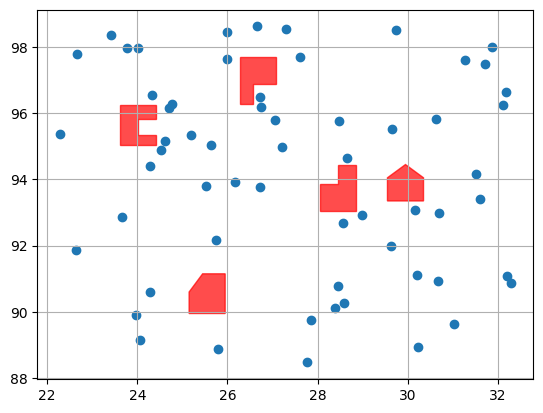

In [3301]:
# creating obstacles
obstacles = {
    0 : [[28.05, 93.05],[28.85, 93.05],[28.85, 94.45], [28.45, 94.45], [28.45, 93.85],[28.05, 93.85],[28.05, 93.05]],
    1 : [[25.15, 89.95],[25.95, 89.95],[25.95, 91.15], [25.45, 91.15], [25.15, 90.60],[25.15, 89.95]],
    2 : [[26.27, 96.29],[26.57, 96.29],[26.57, 96.89], [27.07, 96.89],[27.07, 97.69], [26.27, 97.69], [26.27, 96.29]],
    3 : [[23.62, 95.04],[24.42, 95.04],[24.42, 95.34], [24.02, 95.34], [24.02, 95.84],[24.42, 95.84],[24.42, 96.24],[23.62, 96.24],[23.62, 95.04]],
    4 : [[29.55, 93.35],[30.35, 93.35],[30.35, 94.05], [29.95, 94.45], [29.55, 94.05], [29.55, 93.35]],
}

delivary_loc = remove_obstacle(delivary_loc, obstacles)
extra_loc = []

while (len(extra_loc) != n - len(delivary_loc)):
    extra_loc = create_delivary(x,y,n - len(delivary_loc))
    extra_loc = remove_obstacle(extra_loc, obstacles)
delivary_loc.extend(extra_loc)

primary_plot(delivary_loc, obstacles)

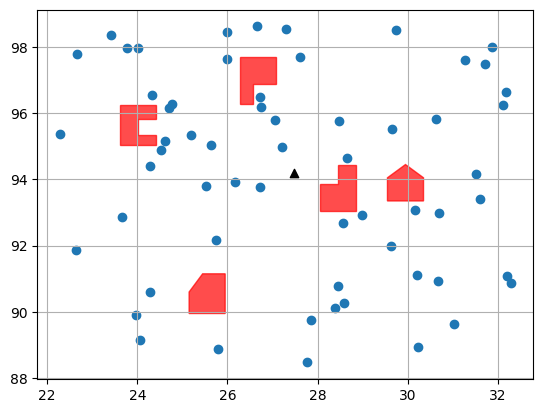

In [3302]:
# creating initial dp
initial_dp = calculate_dp(delivary_loc.copy())
# initial_dp = [28.52, 93.54]

# visualize dp
plot_dp(initial_dp, delivary_loc, obstacles)

*calculate total distance from the initial dp*

In [3303]:
# calculate route
initial_route = create_route(delivary_loc.copy(),initial_dp)

for i in initial_route:
    print(i,"->",end=" ")
print("End")

[27.486549875434658, 94.20214739983761] -> (23.96062782951001, 89.8993729703961) -> [27.486549875434658, 94.20214739983761] -> (31.604739622216933, 93.42317500933696) -> [27.486549875434658, 94.20214739983761] -> (23.423335057341266, 98.35207170754357) -> [27.486549875434658, 94.20214739983761] -> (24.772301645453258, 96.28135606209923) -> [27.486549875434658, 94.20214739983761] -> (31.027298048586132, 89.64858991700537) -> [27.486549875434658, 94.20214739983761] -> (22.64086652336839, 91.88295752373905) -> [27.486549875434658, 94.20214739983761] -> (24.53678787420166, 94.88131395511134) -> [27.486549875434658, 94.20214739983761] -> (28.655326459876047, 94.6553297106122) -> [27.486549875434658, 94.20214739983761] -> (32.28894432359896, 90.86734190126688) -> [27.486549875434658, 94.20214739983761] -> (27.304989442523574, 98.55273890281228) -> [27.486549875434658, 94.20214739983761] -> (28.450639229459725, 90.77077850422216) -> [27.486549875434658, 94.20214739983761] -> (27.8501737152866

Initial Distance : 468.3473551929739


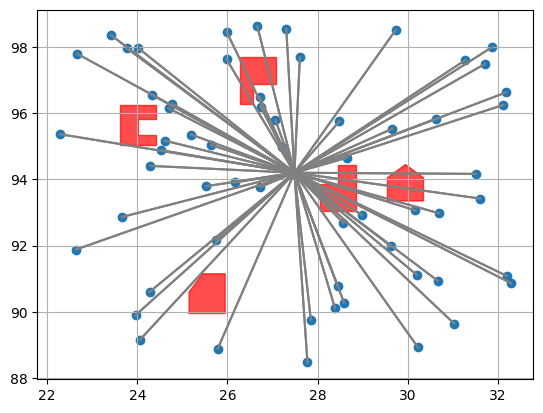

In [3304]:
# calculating distance
initial_dist = total_dist(initial_route)

print("Initial Distance :",initial_dist)

# Visualization
plot_initial_route(initial_dp, delivary_loc, obstacles, initial_route)

In [3305]:
# change dp location if dp on obstacle
calc_dp = varify_dp(initial_dp.copy(), obstacles)

*check for obstacles in the path, if no obstacle then it is optimal dp and optimal path*

--------------------------------------------------
Obstacle avoidance =>
Dp = [27.486549875434658, 94.20214739983761]
Route = [(27.486549875434658, 94.20214739983761), (23.96062782951001, 89.8993729703961), [27.486549875434658, 94.20214739983761], (27.486549875434658, 94.20214739983761), (28.45, 94.45), (29.95, 94.45), (31.604739622216933, 93.42317500933696), (29.95, 94.45), (28.45, 94.45), [27.486549875434658, 94.20214739983761], (27.486549875434658, 94.20214739983761), (23.423335057341266, 98.35207170754357), [27.486549875434658, 94.20214739983761], (27.486549875434658, 94.20214739983761), (24.772301645453258, 96.28135606209923), [27.486549875434658, 94.20214739983761], (27.486549875434658, 94.20214739983761), (28.05, 93.05), (31.027298048586132, 89.64858991700537), (28.05, 93.05), [27.486549875434658, 94.20214739983761], (27.486549875434658, 94.20214739983761), (22.64086652336839, 91.88295752373905), [27.486549875434658, 94.20214739983761], (27.486549875434658, 94.20214739983761), (

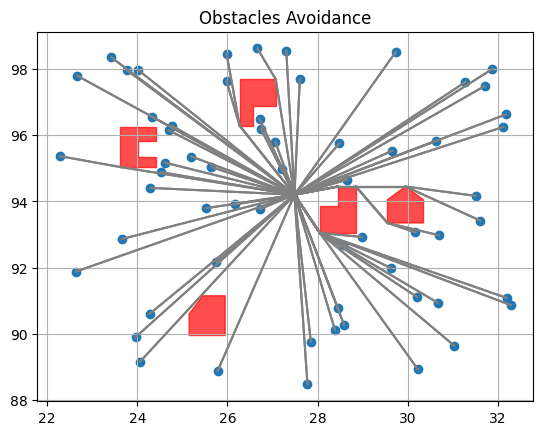

In [3306]:
optimal_dp = None
optimal_route = None
min_distance = float('inf')

for dp in calc_dp:
    new_route, msg = create_shortest_dijkstra_path(dp, delivary_loc.copy(), obstacles)
    if msg == "pass":
        new_dist = total_dist(new_route)
    else:
        new_dist = float('inf')
        new_route = initial_route.copy()

    if new_dist < min_distance:
        min_distance = new_dist
        optimal_dp = dp
        optimal_route = new_route

print("-"*50)
print("Obstacle avoidance =>")
print("Dp =",dp)
print("Route =",new_route)
print("Total distance =",min_distance)
print("-"*50)

plot_initial_route(optimal_dp,delivary_loc, obstacles, optimal_route, "Obstacles Avoidance")

#### <font color="red">Test</font>

In [ ]:
newton_points = newton_points(initial_dp, obstacles, delivary_loc.copy())

New Drone: [27.24493709 94.45475486]
dp: [27.24493709385553, 94.45475486471513] 
delivary locations: [(23.96062782951001, 89.8993729703961), (31.604739622216933, 93.42317500933696), (23.423335057341266, 98.35207170754357), (24.772301645453258, 96.28135606209923), (31.027298048586132, 89.64858991700537), (22.64086652336839, 91.88295752373905), (24.53678787420166, 94.88131395511134), (28.655326459876047, 94.6553297106122), (32.28894432359896, 90.86734190126688), (27.304989442523574, 98.55273890281228), (28.450639229459725, 90.77077850422216), (27.850173715286658, 89.76534019333262), (29.632333173919317, 91.98119107088549), (24.69306258441535, 96.15246005619122), (25.9808851173988, 97.62664512490983), (32.19484736514002, 91.08517203549924), (30.226942367366473, 88.92570150412078), (29.732125818067992, 98.51257606246672), (24.291365123097716, 94.40953819290803), (30.168606452659176, 93.06542956168971), (32.12072594627727, 96.25040520865271), (25.755194970446507, 92.1689769993463), (28.5865

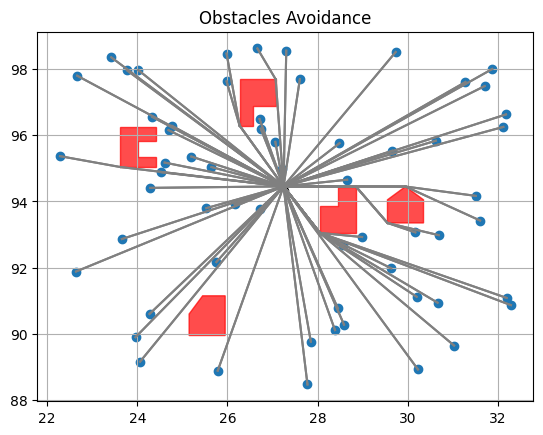

In [3308]:
calc_dp_2 = prone_dp(initial_dp.copy(), obstacles, newton_points)

optimal_dp = None
optimal_route = None
min_distance_2 = float('inf')

for dp in calc_dp_2:
    print(f"dp: {dp} \ndelivary locations: {delivary_loc}")
    new_route, msg = create_shortest_dijkstra_path(dp, delivary_loc.copy(), obstacles)
    if msg == "pass":
        new_dist = total_dist(new_route)
    else:
        new_dist = float('inf')
        new_route = initial_route.copy()

    if new_dist < min_distance_2:
        min_distance_2 = new_dist
        optimal_dp = dp
        optimal_route = new_route

print("-"*50)
print("Obstacle avoidance =>")
print("Dp =",optimal_dp)
print("Route =",new_route)
print("Total distance =",min_distance_2)
print("-"*50)

plot_initial_route(optimal_dp,delivary_loc, obstacles, optimal_route, "Obstacles Avoidance")

## Result

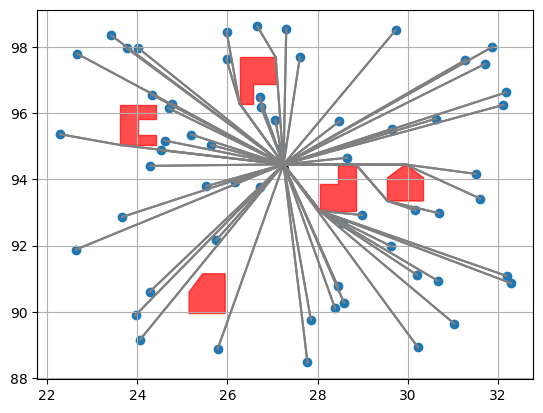

In [3309]:
plot_initial_route(optimal_dp,delivary_loc, obstacles, optimal_route)

## Hold

#### Enhancement of dp

In [3310]:
print(n)
print(len(obstacles))
print(initial_dist)
print(min_distance)
print(min_distance_2)

60
5
468.3473551929739
473.22572569380907
471.0434545225629


In [3311]:
import pandas as pd

df = pd.read_csv('./drone_performance_on_obstacles.csv')

new_row = {
    'delivary_locations':n,
    'drone_capacity':1,
    'obstacles':len(obstacles),
    'obstacle_free_distance':initial_dist,
    'distance_after_obstacle_avoidance':new_dist
}

df.loc[len(df)] = new_row

df.tail(5)

,delivary_locations,drone_capacity,obstacles,obstacle_free_distance,distance_after_obstacle_avoidance
63,60,1,5,479.095156,481.591902
64,60,1,5,451.940052,456.424266
65,60,1,5,481.468345,486.501011
66,60,1,5,449.750765,452.716293
67,60,1,5,468.347355,471.043455


In [3312]:
# try:
#     df.to_csv('./drone_performance_on_obstacles.csv', index=False)
# except:
#     print("Unknown error occurs")